# Optimal Balance

We want to integrate the system in time but slowly disable the nonlinear 
coupling terms between the two oscillators. We do that by slowly ramping epsilon from 1 to zero
(see figure below).

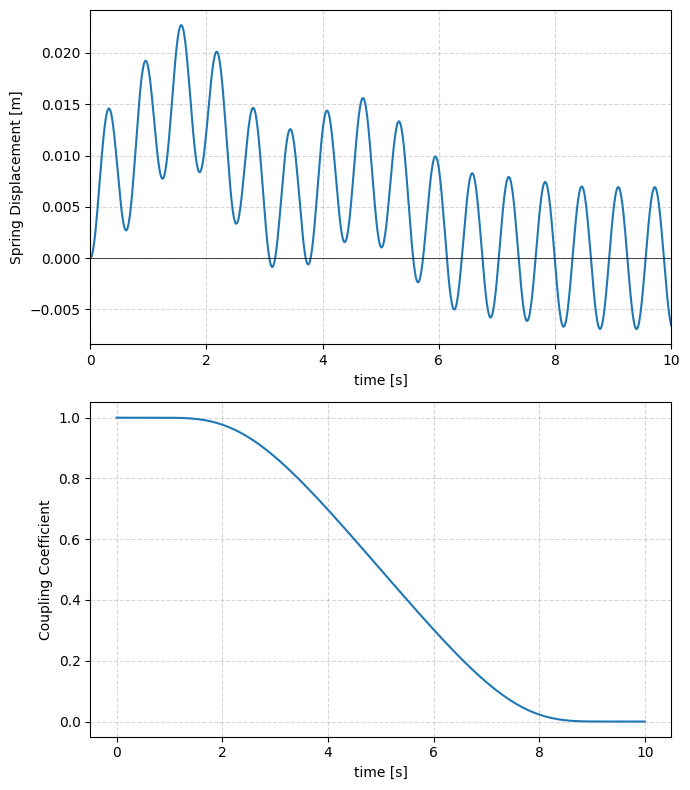

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import coupled_oscillator as co

# defining the parameters
endtime = 4 * np.pi
gravity = 1
mass = 1
length = 1
spring_constant = 10**2  # freqency of spring is 10 times the frequency of pendulum
osc_prop = co.OscillatorProperties(
    gravity=gravity, mass=mass, length=length, spring_constant=spring_constant, epsilon=1)
hamiltonian = co.Hamiltonian(osc_prop)  # This defines the system of equations

# defining the initial conditions
angle_deg = -45
angle_rad = np.deg2rad(angle_deg)
phase_ini = co.Phase(osc_prop, angle=angle_rad)

ramp_period = 10  # The time it takes to ramp down the coupling to zero
epsilon = co.ramp_functions.Exponential(
    start_time=0, period=ramp_period, start_value=1, end_value=0)

# create a new oscillator with the ramped down coupling
osc_prop_ramp = co.OscillatorProperties(
    gravity=gravity, mass=mass, length=length, spring_constant=spring_constant,
    epsilon=epsilon)

# create a new Hamiltonian with the ramped down coupling
ramp_hamiltonian = co.Hamiltonian(osc_prop_ramp)

# solve the system with the ramped down coupling
forwards_evolution = co.solve(
    hamiltonian=ramp_hamiltonian, 
    phase=phase_ini,
    num_points=1000,
    time_span=[0, ramp_period])

# Plot the evolution of the system
fig, ax = plt.subplots(2, 1, figsize=(7, 8), tight_layout=True)
forwards_evolution.displacement.plot(ax=ax[0])
ax[0].grid(True, linestyle="--", alpha=0.5)
ax[0].axhline(0, color='black', lw=0.5)
ax[0].set_xlim(0, 10)

# Plot the epsilon on the second axis

epsilon_values = [epsilon(t) for t in forwards_evolution.time]
ax[1].plot(forwards_evolution.time, epsilon_values)
ax[1].set_xlabel("time [s]")
ax[1].set_ylabel("Coupling Coefficient")
ax[1].grid(True, linestyle="--", alpha=0.5)

In the time evolution of the displacement we find two dominant signals: 
The fast oscillation of the spring and the slow oscillation of the pendulum.
Over time, when the coupling coeeficient goes to zero, the trace of the slow oscillation vanishes. The amplitude of the fast oscillation remains approximately the same (But is it the same?). We can now set the displacement in the uncoupled system to zero, and go back in time to the fully coupled system:

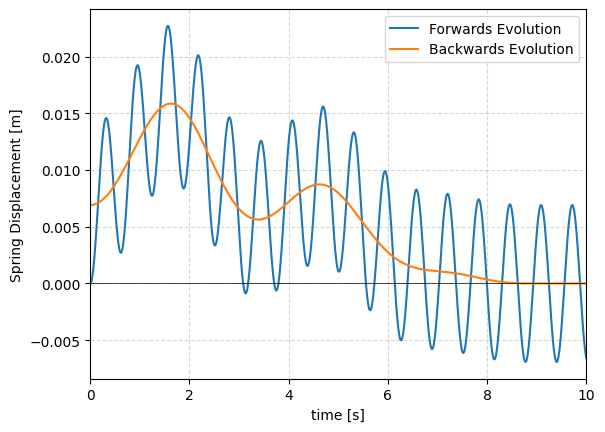

In [2]:
# get the final phase in the uncoupled system
uncoupled_phase = co.Phase.from_xr(osc_prop, forwards_evolution.isel(time=-1))
# eliminate the displacement
eliminate_displacement = co.balancing.NaiveBalancer(hamiltonian).balance
uncoupled_bal_phase = eliminate_displacement(uncoupled_phase, time=0)
# integrate the uncoupled system back to the start
backwards_evolution = co.solve(
    hamiltonian=ramp_hamiltonian, 
    phase=uncoupled_bal_phase,
    num_points=1000,
    time_span=[ramp_period, 0])
# plot the backwards evolution
forwards_evolution.displacement.plot(label="Forwards Evolution")
backwards_evolution.displacement.plot(label="Backwards Evolution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.axhline(0, color='black', lw=0.5)
plt.xlim(0, 10)
plt.legend()

The backwards trajectory follows the forward trajectory, but without any fast oscillations in it.
However, the forwards backwards ramping also has an effect on the angle. Let's compare the difference in angle trajectories between forward and backwards ramping:

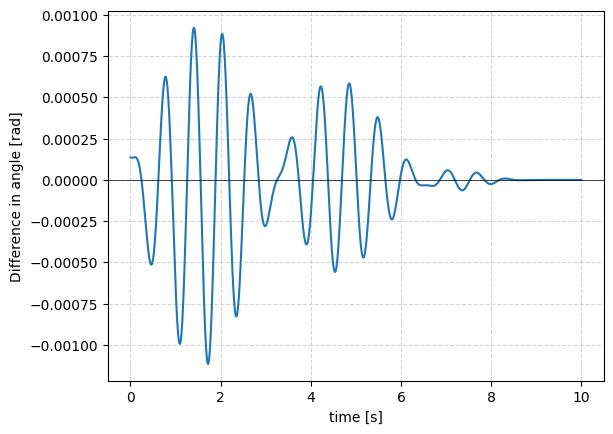

In [3]:
diff_evolution = forwards_evolution.angle.values - backwards_evolution.angle.values[::-1]
plt.plot(forwards_evolution.time, diff_evolution)
plt.xlabel("time [s]")
plt.ylabel("Difference in angle [rad]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.axhline(0, color='black', lw=0.5)

We are especially interested in the angle difference at $t=0$, as we may want to find the balanced state for a given angle. If the initial angle is not the same as the final angle, we may have found a balanced state, but not the balanced state with exactly the angle that we wanted. In the figure above, the difference is very small, but it is not zero. To decrease the error we can set the angle difference of our balanced state to zero (by replacing the balanced angle with the initial angle) and repeat the forwards backwards ramping procedure.

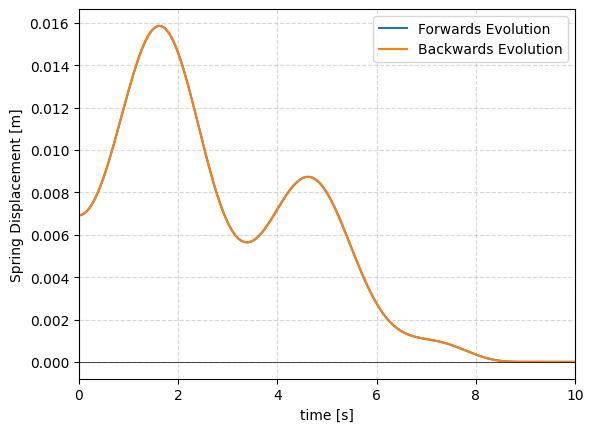

In [4]:
bal_phase = co.Phase.from_xr(osc_prop, backwards_evolution.isel(time=-1))
new_bal_phase = bal_phase - eliminate_displacement(bal_phase, time=0) + eliminate_displacement(phase_ini, time=0)

# integrate the system with the new initial conditions
forwards_evolution = co.solve(
    hamiltonian=ramp_hamiltonian, 
    phase=new_bal_phase,
    num_points=1000,
    time_span=[0, ramp_period])

# get the final phase in the uncoupled system
uncoupled_phase = co.Phase.from_xr(osc_prop, forwards_evolution.isel(time=-1))
# eliminate the displacement
eliminate_displacement = co.balancing.NaiveBalancer(hamiltonian).balance
uncoupled_bal_phase = eliminate_displacement(uncoupled_phase, time=0)
# integrate the uncoupled system back to the start
backwards_evolution = co.solve(
    hamiltonian=ramp_hamiltonian, 
    phase=uncoupled_bal_phase,
    num_points=1000,
    time_span=[ramp_period, 0])
# plot the backwards evolution
forwards_evolution.displacement.plot(label="Forwards Evolution")
backwards_evolution.displacement.plot(label="Backwards Evolution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.axhline(0, color='black', lw=0.5)
plt.xlim(0, 10)
plt.legend()


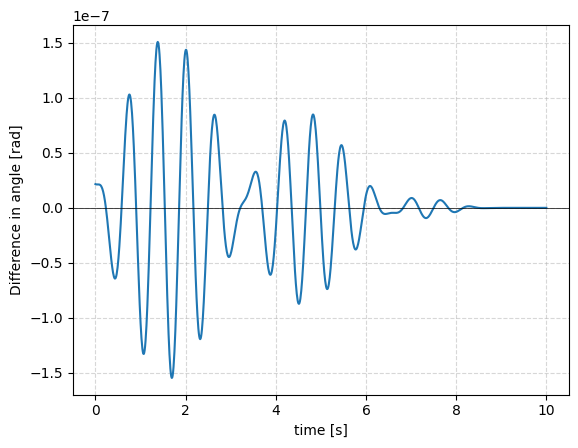

In [5]:
diff_evolution = forwards_evolution.angle.values - backwards_evolution.angle.values[::-1]
plt.plot(forwards_evolution.time, diff_evolution)
plt.xlabel("time [s]")
plt.ylabel("Difference in angle [rad]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.axhline(0, color='black', lw=0.5)

The difference in angle got much smaller! Further, it looks like the previous evolution, just scaled, maybe I could use this?